In [44]:
import timm
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the model
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=3)
checkpoint_path = r"C:\Users\e0l07sq\Desktop\rnd\osteoporosis_project\saved_models\ViT_best.pth"
state_dict = torch.load(checkpoint_path, map_location='cpu')  # or 'cuda' if you're using GPU
model.load_state_dict(state_dict)

# Step 3: Set model to eval mode
model.eval()

# Store attention weights
attn_weights = []

def get_attn_hook(module, input, output):
    # output: tuple, output[1] is the attention weights
    attn_weights.append(output[1])  # The second output is attn map


# Register the hook to the last attention layer
# For ViT in timm, it's usually model.blocks[-1].attn
# handle = model.blocks[-1].attn.attn_drop.register_forward_hook(hook_fn)


In [45]:
from functools import partial

# Save the original forward method
original_attn_forward = model.blocks[-1].attn.forward

def patched_attn_forward(self, x):
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
    q, k, v = qkv.permute(2, 0, 3, 1, 4)

    attn = (q @ k.transpose(-2, -1)) * self.scale
    attn = attn.softmax(dim=-1)

    attn_weights.append(attn.detach())  # 💡 Save attention before dropout
    attn = self.attn_drop(attn)
    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = self.proj(x)
    x = self.proj_drop(x)
    return x

# Patch it
model.blocks[-1].attn.forward = patched_attn_forward.__get__(model.blocks[-1].attn, type(model.blocks[-1].attn))


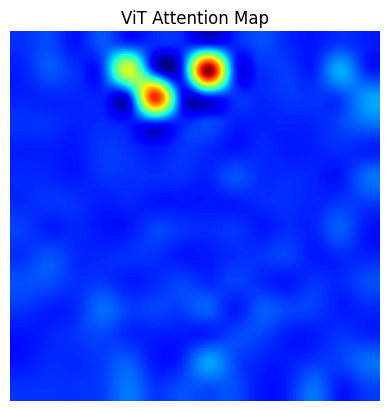

In [50]:
# Load and preprocess the image
image_path = r"C:\Users\e0l07sq\Desktop\rnd\osteoporosis_project\data\cropped_data\Normal\Normal 27_right.png"
img = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Forward pass
with torch.no_grad():
    _ = model(input_tensor)


# Get the attention from the CLS token
attn = attn_weights[0]  # Shape: [batch, heads, tokens, tokens]
cls_attn = attn[0, :, 0, 1:]  # CLS to all patches, ignore CLS->CLS

# Average over heads
mean_attn = cls_attn.mean(dim=0).reshape(14, 14).cpu().numpy()  # ViT has 14x14 patches

# Normalize
mean_attn = (mean_attn - mean_attn.min()) / (mean_attn.max() - mean_attn.min())

# Upsample to image size
import cv2
attn_map = cv2.resize(mean_attn, (224, 224), interpolation=cv2.INTER_CUBIC)

# Show overlay
fig, ax = plt.subplots()
ax.imshow(img.resize((224, 224)))
ax.imshow(attn_map, cmap='jet', alpha=0.999)
plt.axis('off')
plt.title("ViT Attention Map")
plt.show()
